In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import json
import datetime

# Transaction analysis

This section is devoted to the analysis of the collected Bitcoin TXs.

1. We first collected all Bitcoin TXs with *at least one* dust input and/or dust output.
2. We removed all transactions generated by Satoshi Dice (i.e., those with at least one Satoshi Dice address among their inputs).
3. We classified the remaining TXs into four different groups.
    1. Type 1: TXs with exactly 1 unique input address.
    1. Type 2+: TXs with at least 2 unique input addresses.
    3. Type C: TXs with zero input addresses (coincides with *coinbase* transactions).
    4. Type S: TXs where the sum of all input amounts is equal to the fee.

- From step (1) we discovered that 2114335 TXs have at least one dust input and/or output.
- From step (2) we discovered that 649040 TXs have not been generated by Satoshi Dice.

In [2]:
!wc -l data/txs_dust data/txs_dust_nosd

 2114335 data/txs_dust
  649040 data/txs_dust_nosd
 2763375 total


We classified all 649040 transactions that are not related to Satoshi Dice.

In [3]:
txClass = pd.read_csv('data/txs_dust_nosd_class.csv', header=None)
txClass.columns = ['txId', 'blockId', 'type']
print(f'N. of TXs:\t{len(txClass)}')
txClass.head()

N. of TXs:	649040


,txId,blockId,type
0,121385,82560,1
1,121386,82560,1
2,121403,82561,1
3,121404,82561,1
4,121405,82561,1


- Most of these dust transactions (approximately 65%) belong to the "Type 1" category (i.e., they have exactly 1 unique input address).
- The "Type 2+" category (the most interesting one for successful dust attacks) includes approximately 33% of all TXs.
- There are also 19 transactions classified as "Special", and their inputs are all spent as fees.

In [4]:
pd.DataFrame({'TXs' : txClass.type.value_counts(), 'Percentage' : (txClass.type.value_counts()*100)/len(txClass)})

,TXs,Percentage
1,421094,64.879514
2+,216628,33.376679
C,11299,1.740879
S,19,0.002927


## Special type

Now we would like to identify the 19 transactions that have been classified as "Special".

In [5]:
txClass[txClass.type == 'S']

,txId,blockId,type
289444,15367109,229265,S
292602,15579990,229814,S
424386,26889044,269132,S
442535,30379718,278511,S
448499,32006969,283392,S
478961,42453637,310571,S
490064,45576189,318089,S
548625,49860416,327218,S
548626,49860421,327218,S
550037,50185095,327766,S


To translate the `txId` to real TX hash, we import the CSV file with the id-to-hash mapping (and then we perform a join on the `txId` attribute of both tables).

In [6]:
txId2Hash = pd.read_csv('data/txId2Hash.csv', header=None)
txId2Hash.columns = ['txId', 'txHash']
txId2Hash

,txId,txHash
0,121385,46b640bcc5395bd6dfde5ec0f2331331b5a4c429e2026a...
1,121386,2b26e886366ec0e08e32866077c46b849e16358f119339...
2,121403,b2f229cf36cf154e254ccc8e21d46ae02fd202a33be892...
3,121404,9d3a11cddc72da6ba0fac7f3a6d370641297db5e329701...
4,121405,85e97e84c5a23063f2afddb03202234f0ee5d7b9a07339...
...,...,...
649035,245354280,d452949aadea80aa64e669565062548a29de00c6ee4f35...
649036,245368332,a0275bc4c4ddf44f569dd67759a07121280760c00b5e61...
649037,245369115,7f1b5d146ec8b8a3a1aabf799a1bcf3ecf69b71feaef62...
649038,245369137,175801edf4fbfd8843f32146f3b05ae3752b6f03494c8c...


In [7]:
special = txClass[txClass.type == 'S'].merge(txId2Hash, how='left', on='txId')
special.to_csv('data/special/special.csv', index=False)
special

,txId,blockId,type,txHash
0,15367109,229265,S,46aa1784c28fb40b0e4351c599d13d6224dfa389273e27...
1,15579990,229814,S,98069c9c8770c4fd1cc73070ee3da07f55284bb62591e8...
2,26889044,269132,S,499e80a173ee095d44b1c3503c5d00015222a2d7c17a21...
3,30379718,278511,S,6164cb05c04d6700ff2cda18f1ba2824d3d02eb782a557...
4,32006969,283392,S,bd5c650f11b0c67365efc6dfb039fbf23f9187455d1e92...
5,42453637,310571,S,52a16a4b7e7376f25151c7362adf3fd5165ae91d013ea6...
6,45576189,318089,S,f482cc27c67f28c037029e45f96b05789e9ca38e7f0ed0...
7,49860416,327218,S,af96ece904c947057e1dee4f84fdca51e277bfd1f58a78...
8,49860421,327218,S,499028aa9984a0d891823a17e0a5c3ab8e8d49b560d9b9...
9,50185095,327766,S,4e59ed6c80aa59e9a3a90b5f655965830cbfb96599a587...


We download the TX details in JSON format.

We would like to analyze the most frequent input addresses of these transactions and, if possible, to link those addresses to real entities (mining pools, known users, etc.). We found out that:

1. The 19 transactions labeled as "Special" contain 195 distinct input addresses.

2. The most frequent address is `1KvagQN1tuzyDDi8AbasfL28n8GhSt6VNS` (https://www.blockchain.com/btc/address/1KvagQN1tuzyDDi8AbasfL28n8GhSt6VNS). 

3. The address `15ArtCgi3wmpQAAfYx4riaFmo4prJA4VsK` belongs to Bitcoin Faucet (https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1410&context=open_access_dissertations).

4. The address `1JwhpLueAh8cRs8bunPpqKYEuqcyhakqDq` belongs to the AnxPro.com wallet. (https://www.walletexplorer.com/address/1JwhpLueAh8cRs8bunPpqKYEuqcyhakqDq)

In [42]:
inputAddresses = []
for h in special.txHash:
    with open('data/special/tx_{}.json'.format(h), 'r') as inputFile:
        f = json.load(inputFile)
        # txHash = f['hash']
        for i in f['inputs']:
            address = i['prev_out']['addr']
            inputAddresses.append(address) #f'{address},{txHash}')
specialInputs = pd.Series(inputAddresses)

In [90]:
specialInputs.value_counts()

1KvagQN1tuzyDDi8AbasfL28n8GhSt6VNS    200
156PpY1F8g5vB3x7DCpmguWEv1uiPH7tWE    146
18cd7WSYc5nh4DPwsZfvLVABUTbfPERjpP     90
1JMmnNou7TJj7W9dtQeUBwa1eKkHWcCTG5     34
1ErAcf4RHtuXML6KGoPNPeHTgZLqusjPm2     31
                                     ... 
1Krv5AcayGKqhWsEnDBK2fJUuvULSg6bkX      1
19oz84YBA8iKCfQ3AvUzhauJ6BFv2C86R5      1
1Au5KSY7RKDm44JfyYeYf4T1Jgqsss14tk      1
1919Jp8AGM3wEMdX5Q7ktTXi4yyJ5Q76o3      1
1ApgR2ZD3wyceHJZmByAzerGHUaBXVx8YX      1
Length: 195, dtype: int64

In [91]:
specialInputs.value_counts().nlargest(10)

1KvagQN1tuzyDDi8AbasfL28n8GhSt6VNS    200
156PpY1F8g5vB3x7DCpmguWEv1uiPH7tWE    146
18cd7WSYc5nh4DPwsZfvLVABUTbfPERjpP     90
1JMmnNou7TJj7W9dtQeUBwa1eKkHWcCTG5     34
1ErAcf4RHtuXML6KGoPNPeHTgZLqusjPm2     31
15ArtCgi3wmpQAAfYx4riaFmo4prJA4VsK     27
1DHFiDNHDDNoR4f1tekaeNKYPWf7JucSU2     26
13KPpBpNRHKQihqwYnHu97miU4ikSVareR     19
1JwhpLueAh8cRs8bunPpqKYEuqcyhakqDq     14
14iK1RiiXDRQ4deZ1zWMeyAbQixFimUES5     13
dtype: int64

# Input and output analysis

In this section we examine all inputs and outputs of all collected transactions. Recall that we have collected all transactions with at least one dust input and/or one dust output.

In [6]:
inputs = pd.read_csv('data/txs_dust_nosd_inputs.csv')
outputs = pd.read_csv('data/txs_dust_nosd_outputs.csv')
inputs['timestamp'] = inputs['timestamp'].values.astype(dtype='datetime64[s]')
outputs['timestamp'] = outputs['timestamp'].values.astype(dtype='datetime64[s]')

In [7]:
inputs.head()

,timestamp,blockId,txId,address,amount,prevTxId,prevTxOffset
0,2010-09-28 09:28:09,82560,121385,118901,9988099000,121384,0
1,2010-09-28 09:28:09,82560,121386,118902,9987098901,121385,1
2,2010-09-28 09:41:04,82561,121403,118918,9970398802,121402,1
3,2010-09-28 09:41:04,82561,121404,118919,9969398703,121403,1
4,2010-09-28 09:41:04,82561,121405,118920,9968398604,121404,1


In [8]:
outputs.head()

,timestamp,blockId,txId,address,amount,scriptType,offset
0,2010-09-28 09:28:09,82560,121385,118890,99,2,0
1,2010-09-28 09:28:09,82560,121385,118902,9987098901,2,1
2,2010-09-28 09:28:09,82560,121386,118890,99,2,0
3,2010-09-28 09:28:09,82560,121386,118903,9986098802,2,1
4,2010-09-28 09:41:04,82561,121403,118890,99,2,0


We first print the total number of inputs and outputs. These also include non-dust amounts.

In [9]:
print('N. of inputs:\t{}\nN. of outputs:\t{}'.format(len(inputs),len(outputs)))

N. of inputs:	8594633
N. of outputs:	5497171


How many inputs and outputs fall within the dust range $[1, 545]$?

In [10]:
inputs_dust = inputs[(inputs.amount >= 1) & (inputs.amount <= 545)]
outputs_dust = outputs[(outputs.amount >= 1) & (outputs.amount <= 545)]
inputs_non_dust = inputs[inputs.amount > 545]
outputs_non_dust = outputs[outputs.amount > 545]
print('Dust inputs:\t{}\t\t(% over total: {})\nDust outputs:\t{}\t\t(% over total: {})\n'.format(len(inputs_dust), len(inputs_dust)*100/len(inputs), len(outputs_dust), len(outputs_dust)*100/len(outputs)))
print('Non-dust inputs:\t{}\t\t(% over total: {})\nNon-dust outputs:\t{}\t\t(% over total: {})\n'.format(len(inputs_non_dust), len(inputs_non_dust)*100/len(inputs), len(outputs_non_dust), len(outputs_non_dust)*100/len(outputs)))

Dust inputs:	2559078		(% over total: 29.775302796524297)
Dust outputs:	2935933		(% over total: 53.40807116969801)

Non-dust inputs:	6035171		(% over total: 70.22022929891247)
Non-dust outputs:	2557942		(% over total: 46.53197071730168)



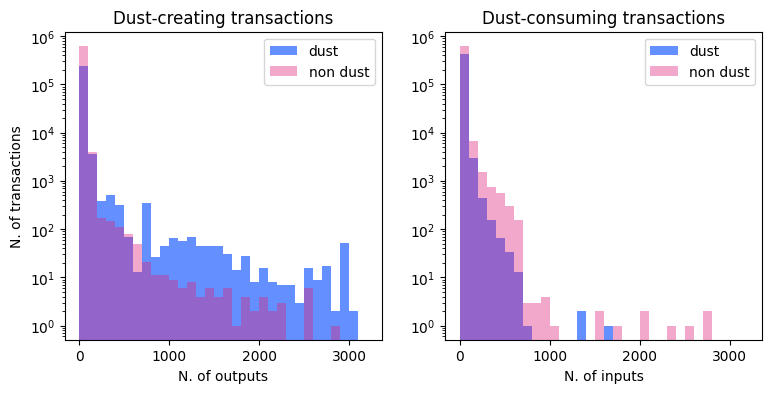

In [11]:
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Dust-creating transactions')
ax1.set_xlabel('N. of outputs')
ax1.set_ylabel('N. of transactions')
ax1.set_yscale('log')
ax1.hist(outputs_dust.groupby('txId').size().values, color='#648fff', range=[0, 3200], bins=32, label='dust')
ax1.hist(outputs_non_dust.groupby('txId').size().values, color='#dc267f', alpha=.4, range=[0, 3200], bins=32, label='non dust')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax2.set_title('Dust-consuming transactions')
ax2.set_xlabel('N. of inputs')
ax2.set_yscale('log')
ax2.hist(inputs_dust.groupby('txId').size().values, color='#648fff', range=[0, 3200], bins=32, label='dust')
ax2.hist(inputs_non_dust.groupby('txId').size().values, color='#dc267f', alpha=.4, range=[0, 3200], bins=32, label='non dust')
ax2.legend(loc='upper right')

plt.show()

In [12]:
outputs_dust_year = outputs_dust.groupby([outputs_dust.timestamp.dt.year]).count()['txId'].rename('count')
outputs_non_dust_year = outputs_non_dust.groupby([outputs_non_dust.timestamp.dt.year]).count()['txId'].rename('count')
inputs_dust_year = inputs_dust.groupby([inputs_dust.timestamp.dt.year]).count()['txId'].rename('count')
inputs_non_dust_year = inputs_non_dust.groupby([inputs_non_dust.timestamp.dt.year]).count()['txId'].rename('count')

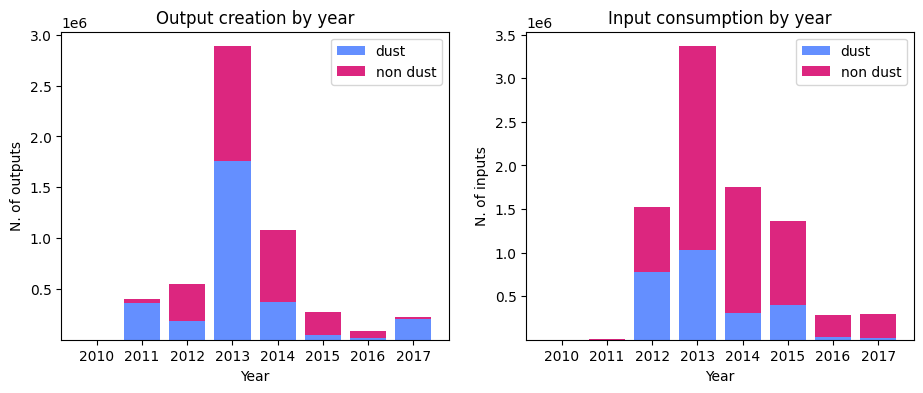

In [13]:
fig = plt.figure(figsize=(11,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Output creation by year')
ax1.set_xlabel('Year')
ax1.set_ylabel('N. of outputs')
ax1.bar(outputs_dust_year.index, outputs_dust_year, color='#648fff', label='dust')
ax1.bar(outputs_non_dust_year.index, outputs_non_dust_year, color='#dc267f', label='non dust', bottom=outputs_dust_year)
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Input consumption by year')
ax2.set_xlabel('Year')
ax2.set_ylabel('N. of inputs')
ax2.bar(inputs_dust_year.index, inputs_dust_year, color='#648fff', label='dust')
ax2.bar(inputs_non_dust_year.index, inputs_non_dust_year, color='#dc267f', label='non dust', bottom=inputs_dust_year)
ax2.legend(loc='upper right')

plt.show()

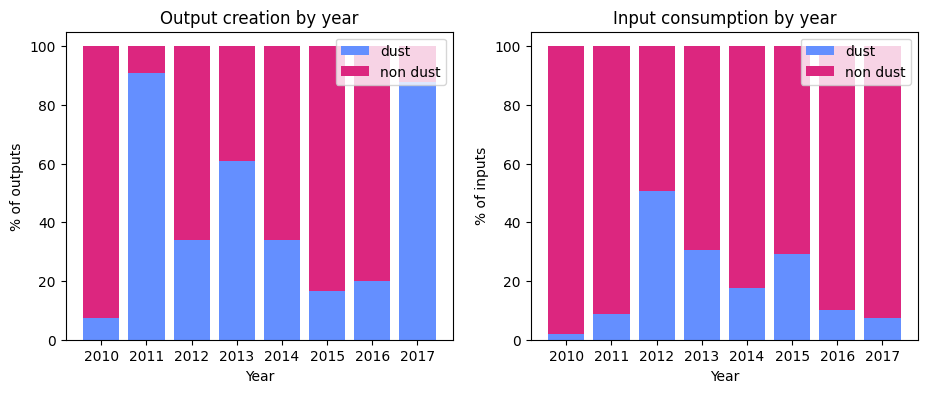

In [14]:
# Compute percentages for outputs.
x1 = pd.DataFrame({'dust':outputs_dust_year,'nondust':outputs_non_dust_year}).reset_index()
x1['sum'] = x1.dust + x1.nondust
x1['dust'] = (x1['dust'] / x1['sum'])*100
x1['nondust'] = (x1['nondust'] / x1['sum'])*100
x1 = x1.round(2)
x1 = x1.drop('sum', axis=1)

# Compute percentages for inputs.
x2 = pd.DataFrame({'dust':inputs_dust_year,'nondust':inputs_non_dust_year}).reset_index()
x2['sum'] = x2.dust + x2.nondust
x2['dust'] = (x2['dust'] / x2['sum'])*100
x2['nondust'] = (x2['nondust'] / x2['sum'])*100
x2 = x2.round(2)
x2 = x2.drop('sum', axis=1)

fig = plt.figure(figsize=(11,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Output creation by year')
ax1.set_xlabel('Year')
ax1.set_ylabel('% of outputs')
ax1.bar(x1.timestamp, x1.dust, color='#648fff', label='dust')
ax1.bar(x1.timestamp, x1.nondust, color='#dc267f', label='non dust', bottom=x1.dust)
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Input consumption by year')
ax2.set_xlabel('Year')
ax2.set_ylabel('% of inputs')
ax2.bar(x2.timestamp, x2.dust, color='#648fff', label='dust')
ax2.bar(x2.timestamp, x2.nondust, color='#dc267f', label='non dust', bottom=x2.dust)
ax2.legend(loc='upper right')

plt.show()

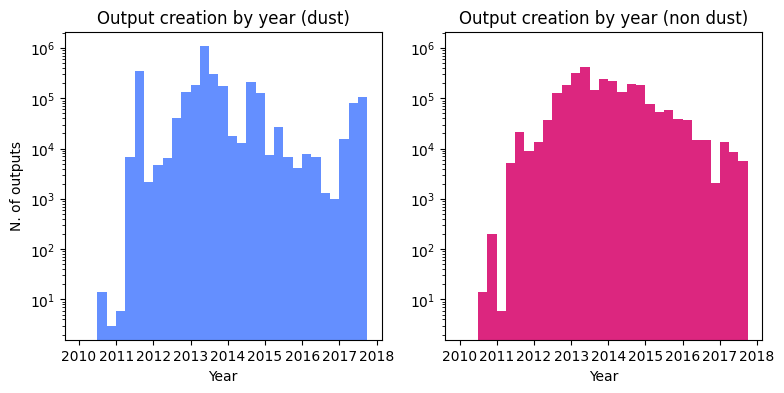

In [23]:
l1 = mdates.date2num(outputs_dust.timestamp.values)
l2 = mdates.date2num(outputs_non_dust.timestamp.values)
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
months = [i for i in range(1, 12+1, 3)]
bins = []
for y in years:
    for m in months:
        bins.append(datetime.date(y, m, 1))
hist_bins = mdates.date2num(bins)

fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Output creation by year (dust)')
ax1.set_xlabel('Year')
ax1.set_ylabel('N. of outputs')
ax1.set_yscale('log')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.hist(l1, bins=hist_bins, color='#648fff', label='dust')
#ax1.legend(loc='upper left')

ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax2.set_title('Output creation by year (non dust)')
ax2.set_xlabel('Year')
#ax2.set_ylabel('N. of outputs')
ax2.set_yscale('log')
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.hist(l2, bins=hist_bins, color='#dc267f', label='non dust')
#ax2.legend(loc='upper left')


plt.show()

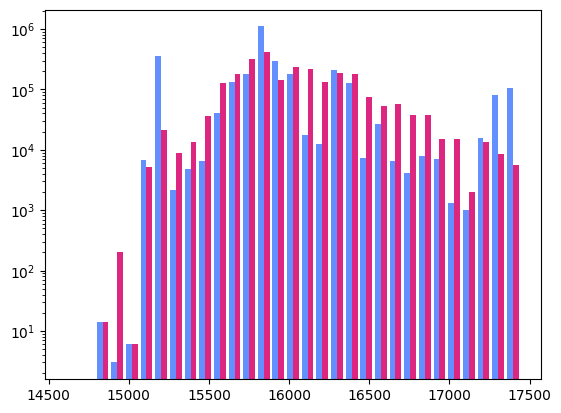

In [36]:
plt.hist([l1,l2], bins=hist_bins, histtype='bar', color=['#648fff', '#dc267f'], label=['dust', 'nondust'])
plt.yscale('log')
plt.show()

# Address analysis

We first import the addressId-to-hash map, which allows us to transform numeric identifiers into real Bitcoin addresses.

In [39]:
addrId2Hash = pd.read_csv('data/addrId2Hash.csv', header=None)
addrId2Hash.columns = ['address', 'addrHash']
addrId2Hash

,address,addrHash
0,0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa
1,1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX
2,2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1
3,7,16LoW7y83wtawMg5XmT4M3Q7EdjjUmenjM
4,9,12cbQLTFMXRnSzktFkuoG3eHoMeFtpTu3S
...,...,...
3306381,293711368,14vDZqHhHdQcq3NY9q4R7yi9AUAua97UXE
3306382,293713061,17taxuZZkBTANgg4eLom9iDDDkzcJ2Q6n3
3306383,293732908,1AbnA58nh4StjnkpRajAVNM2HFX1eHAipW
3306384,293733650,1CwTP6C3NWRJ5hv7U9gVdgYbqM28Ho1RZN


We also import the table with all known Satoshi Dice addresses.

In [78]:
satoshi_dice = pd.read_csv('data/satoshi_dice_full.csv')
satoshi_dice.rename(columns={"address": "addrHash", "id": "address"}, inplace=True)
satoshi_dice

,name,addrHash,win_odds,price_multiplier,house_percent,expected_return,min_bet,max_bet,address
0,lessthan 60000,1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc,91.5527%,1.071x,1.900%,98.100%,0.01,500.0000,5028176
1,lessthan 56000,1dicegEArYHgbwQZhvr5G9Ah2s7SFuW1y,85.4492%,1.147x,1.900%,98.100%,0.01,500.0000,5028570
2,lessthan 52000,1dicec9k7KpmQaA8Uc8aCCxfWnwEWzpXE,79.3457%,1.235x,1.900%,98.100%,0.01,500.0000,5029468
3,lessthan 48000,1dice9wcMu5hLF4g81u8nioL5mmSHTApw,73.2422%,1.338x,1.900%,98.100%,0.01,500.0000,3517367
4,lessthan 32768,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6,50.0000%,1.957x,1.900%,98.100%,0.01,463.5871,3517636
5,lessthan 32000,1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp,48.8281%,2.004x,1.900%,98.100%,0.01,441.9523,3524394
6,lessthan 24000,1dice7W2AicHosf5EL3GFDUVga7TgtPFn,36.6211%,2.670x,1.900%,98.100%,0.01,396.0801,3524243
7,lessthan 16000,1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx,24.4141%,4.003x,1.900%,98.100%,0.01,321.1334,3534212
8,lessthan 12000,1dice7EYzJag7SxkdKXLr8Jn14WUb3Cf1,18.3105%,5.335x,1.900%,98.100%,0.01,222.4240,3535501
9,lessthan 8000,1dice6YgEVBf88erBFra9BHf6ZMoyvG88,12.2070%,8.000x,1.900%,98.100%,0.01,176.8535,3525822


## Top receivers

1. We analyze the top receivers by computing the number of outputs associated to each address. 
2. We take the top 20 positions.
3. Most of them are related to Satoshi Dice.

In [85]:
s = outputs.address.value_counts().nlargest(20)
df = pd.DataFrame({'address': s.index, 'count': s.values}).merge(addrId2Hash, how='left', on='address')
df = df.merge(satoshi_dice, how='left', on='address')
df = df[['address','count','addrHash_x','name']]
df['percentage'] = (df['count'] / len(outputs))*100
df

,address,count,addrHash_x,name,percentage
0,3108769,146827,1JwSSubhmg6iPtRjtyqhUYYH7bZg3Lfy1T,NaN,2.670956
1,3517636,52120,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6,lessthan 32768,0.948124
2,3524394,51396,1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp,lessthan 32000,0.934954
3,3517367,29716,1dice9wcMu5hLF4g81u8nioL5mmSHTApw,lessthan 48000,0.540569
4,3534212,22744,1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx,lessthan 16000,0.413740
5,3524243,22072,1dice7W2AicHosf5EL3GFDUVga7TgtPFn,lessthan 24000,0.401516
6,3525822,15617,1dice6YgEVBf88erBFra9BHf6ZMoyvG88,lessthan 8000,0.284092
7,5028176,13446,1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc,lessthan 60000,0.244599
8,3525858,13187,1dice1e6pdhLzzWQq7yMidf6j8eAg7pkY,lessthan 1,0.239887
9,3526385,12222,1dice5wwEZT2u6ESAdUGG6MHgCpbQqZiy,lessthan 1000,0.222333


In [92]:
df[df.name.isna()]

,address,count,addrHash_x,name,percentage
0,3108769,146827,1JwSSubhmg6iPtRjtyqhUYYH7bZg3Lfy1T,NaN,2.670956
11,2931635,8936,18d3HV2bm94UyY4a9DrPfoZ17sXuiDQq2B,NaN,0.162556
12,77484108,8484,1DWootvp5LToyqF9Gf2dm53i5yvjqpLJYM,NaN,0.154334
14,7094576,6823,1AVFypuG2jUrYzjZa69C7hK59XkWUwvK1m,NaN,0.124118
17,7470171,4031,1PEDJAibfNetJzM289oXsW1qLAgjYDjLgN,NaN,0.073329
18,7077012,3519,1A4tii76NcMFLPdqNNqMgb8hN9U3QjMu1m,NaN,0.064015
19,8302299,3519,1Dy653qDGdrshqi6exaDQrUsmQ71fhgfjb,NaN,0.064015


What happens if we select only all dust outputs? We repeat the previous analysis.
Most Satoshi Dice addresses disappear.

1. `1JwSSubhmg6iPtRjtyqhUYYH7bZg3Lfy1T` => "correct horse battery staple" brainwallet
2. `18d3HV2bm94UyY4a9DrPfoZ17sXuiDQq2B` => Eligius mining pool
3. `1PEDJAibfNetJzM289oXsW1qLAgjYDjLgN` => Unknown (https://bitcointalk.org/index.php?topic=127531.msg1354584#msg1354584)
4. `16LQodsvHtydHPrsFqBw63c8z6R2F8Nayt` => Unknown
5. `1Dy653qDGdrshqi6exaDQrUsmQ71fhgfjb` => NakaBot player (https://bitcointalk.org/index.php?topic=117917.440)
6. `1L5RocLmUfWHNdcDBwTqFAQPxYxbs7XGAn` => Unknown
7. `1A4tii76NcMFLPdqNNqMgb8hN9U3QjMu1m` => Unknown (https://bitcointalk.org/index.php?topic=22434.160)
8. `16FLHNYbQt8WejYcT5NZar8XFq1X7tpB72` => Unknown
9. `1BGbGFBhsXYq6kTyjSC9AHRe1dhe76tD6i` => Possible miner (Here https://www.blockchain.com/btc/tx/ac8cd4fef5a46f32afb6245a7508dcad3ca60ad3d2faececaf969b5eb85bf1c4 in combination with a known Eligius address http://eligius.st/~wizkid057/newstats/userstats.php/1Nbq2XZaRsKknf5fcT2wTXvBS31PaUWSeX. )
10. `1B3n6VrdEL6wAkazQiJyQURr9MmghBxUEy` => Unknown
11. `195RK2kUTiNGspe9k9KdVoK4ES3gNuos4G` => Unknown
12. `1DNNERMT5MMusfYnCBfcKCBjBKZWBC5Lg2` => BitHits (https://bitcointalk.org/index.php?action=profile;u=82731, https://web.archive.org/web/20150622024433/http://beta.bithits.info/)

In [94]:
s = outputs_dust.address.value_counts().nlargest(20)
df = pd.DataFrame({'address': s.index, 'count': s.values}).merge(addrId2Hash, how='left', on='address')
df = df.merge(satoshi_dice, how='left', on='address')
df = df[['address','count','addrHash_x','name']]
df['percentage'] = (df['count'] / len(outputs))*100
df

,address,count,addrHash_x,name,percentage
0,3108769,146821,1JwSSubhmg6iPtRjtyqhUYYH7bZg3Lfy1T,NaN,2.670847
1,2931635,8099,18d3HV2bm94UyY4a9DrPfoZ17sXuiDQq2B,NaN,0.147330
2,7470171,3579,1PEDJAibfNetJzM289oXsW1qLAgjYDjLgN,NaN,0.065106
3,6399180,2581,16LQodsvHtydHPrsFqBw63c8z6R2F8Nayt,NaN,0.046951
4,8302299,2402,1Dy653qDGdrshqi6exaDQrUsmQ71fhgfjb,NaN,0.043695
5,17459781,1926,1L5RocLmUfWHNdcDBwTqFAQPxYxbs7XGAn,NaN,0.035036
6,7077012,1825,1A4tii76NcMFLPdqNNqMgb8hN9U3QjMu1m,NaN,0.033199
7,4416784,1671,16FLHNYbQt8WejYcT5NZar8XFq1X7tpB72,NaN,0.030397
8,29055321,1625,1BGbGFBhsXYq6kTyjSC9AHRe1dhe76tD6i,NaN,0.029561
9,8565622,1499,1B3n6VrdEL6wAkazQiJyQURr9MmghBxUEy,NaN,0.027269
